<a href="https://colab.research.google.com/github/ninavdPipple/BERTopic/blob/master/Small_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install typing_extensions --upgrade
!pip install bertopic
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
!pip install kora -q
from kora import drive
drive.link_nbs()
from Evaluation_BERTopic_repo import Trainer, DataLoader, Evaluator
!python -m pip install tomotopy
!pip install octis
from octis.dataset.dataset import Dataset
import os
import requests
import json
import numpy as np
!pip install openai
import openai
from openai import AzureOpenAI

  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 14.0 MB/s eta 0:00:00
  Prep

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [3]:
# Connecting to GPT model

client = AzureOpenAI(
    api_key="139ff4ea58234550972e6f5db98b30a7",
    api_version='2023-05-15',
    azure_endpoint = "https://510-openai.openai.azure.com/"
)

deployment_name='510-chat' #This will correspond to the custom name you chose for your deployment when you deployed a model.

In [ ]:
# # Example ussage of GPT model
# print('Sending a test completion job')
# start_phrase = start_phrase = """
# This is a list of taglines for different types of stores, that could attract customers.
# ---
# Sports store: Take your fitness to the next level!
# ---
# Plant store: The greener the better.
# ---
# Ice cream store: """
# response = client.completions.create(model=deployment_name, prompt=start_phrase, max_tokens=30)
# print(response.choices[0].text)

In [5]:
# Pick model for output
model = 'Low_preprocess'

# Create folder if model doesn't exist yet
new_model = not os.path.exists(f"/content/drive/MyDrive/2024/{model}")
if new_model:
   os.makedirs(f"/content/drive/MyDrive/2024/{model}")

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', -1) # make sure to print entire messages when printed form dataframe
import regex as re

# Load data
raw_data = pd.read_excel('/content/drive/MyDrive/messages_2023_list.xlsx')

# # Pick small subset if performing costly operations
# if model == 'Model_small_data':
#   raw_data = raw_data.iloc[:100]

# Remove enters in label names
raw_data['label'] =  raw_data['label'].apply(lambda x: re.sub(r'\n','', str(x)))


In [7]:
# Remove urls
print('Instances containing https: ', sum(raw_data['text'].str.contains(r'https')))
raw_data['text'] = raw_data['text'].apply(lambda x: re.sub(r'\(https[^\)]*\)',' <URL> ', str(x))) # Remove based on brackets
raw_data['text'] = raw_data['text'].apply(lambda x: re.sub(r'https[\S]*','<URL>', str(x))) # Remove based on followed by a space or enter
print('Instances containing https: ', sum(raw_data['text'].str.contains(r'https')))

# Remove any remaining Ukrainian text
print('Instances containing Ukrain: ', sum(raw_data['text'].str.contains(r'[А-ЩЬЮЯҐЄІЇа-щьюяґєії]')))
raw_data['OCTIS'] =  raw_data['text'].apply(lambda x: re.sub(r'\p{IsCyrillic}','', str(x)))
print('Instances containing Ukrain: ', sum(raw_data['OCTIS'].str.contains(r'[А-ЩЬЮЯҐЄІЇа-щьюяґєії]')))

# Manually remove <> if they are not around any of the markers (PERSON, URL, ect)
def clean_text(text):
    pattern = r'<(?!PERSON>|URL>|CREDIT_CARD>|EMAIL_ADDRESS>|PHONE_NUMBER>)(.*?)>'
    cleaned_text = re.sub(pattern, r'\1', text)
    return cleaned_text

# raw_data['OCTIS'] = raw_data['OCTIS'].apply(clean_text)

# Remove enters within message and save
raw_data['OCTIS'] =  raw_data['OCTIS'].apply(lambda x: re.sub(r'\n',' ', str(x)))
raw_data['OCTIS'].to_csv('/content/drive/MyDrive/2024/documents_stripped.csv', index=False, encoding="utf-8-sig")
raw_data['label'].to_csv('/content/drive/MyDrive/2024/labels.csv', index=False, encoding="utf-8-sig")

Instances containing https:  51
Instances containing https:  0
Instances containing Ukrain:  38
Instances containing Ukrain:  0


In [8]:
# import string
# # from octis.preprocessing.preprocessing import Preprocessing
# from OCTIS_preprocess_repo import Preprocessing
# os.chdir(os.path.pardir)

# # Initialize preprocessing
# preprocessor = Preprocessing(lowercase=False,
#                 remove_punctuation=False,
#                 punctuation=string.punctuation,
#                 remove_numbers=False,
#                 lemmatize=False,
#                 language="english",
#                 split=False,
#                 verbose=True,
#                 save_original_indexes=True,
#                 remove_stopwords_spacy=False,)

# # preprocess
# # SMILEYS AUTOMATICALLY REMOVED
# dataset = preprocessor.preprocess_dataset(documents_path=r'/content/drive/MyDrive/2024/documents_stripped.csv', labels_path=r'/content/drive/MyDrive/2024/labels.csv')

# # save the preprocessed dataset
# dataset.save('/content/drive/MyDrive/2024/ukraine')

importing Jupyter notebook from /nbs/OCTIS_preprocess_repo.ipynb


100%|██████████| 4522/4522 [00:00<00:00, 258520.88it/s]


created vocab
9980
words filtering done


In [9]:
# Load a dataset
dataset = Dataset('ukraine')
dataset.load_custom_dataset_from_folder('/content/drive/MyDrive/2024/ukraine')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


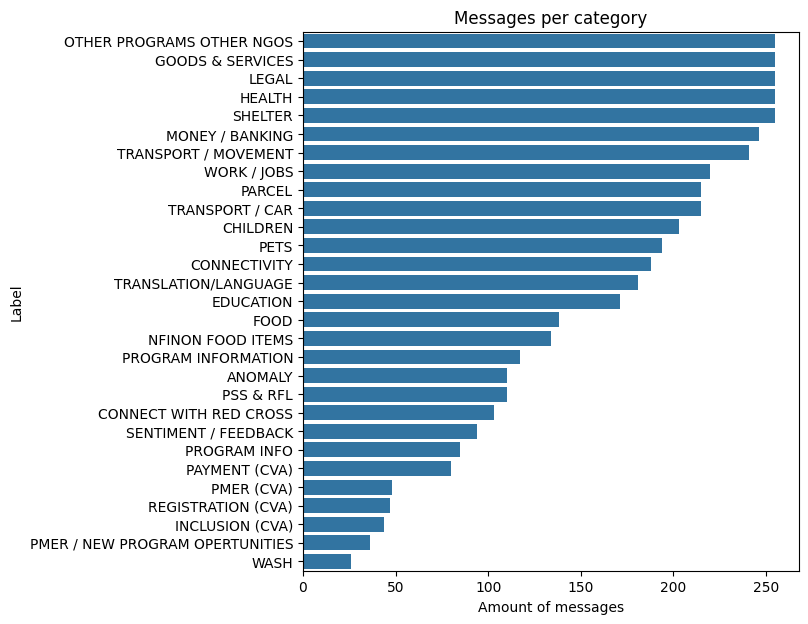

In [14]:
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

# Analyze data

list_data = dataset.get_corpus()
data = [" ".join(words) for words in list_data]

#%%

# Overview of categories
plt.figure().set_figheight(7)
# sns.histplot(y = raw_data['label'])
sns.countplot(y = 'label', data=raw_data, order = raw_data['label'].value_counts().index)
plt.title('Messages per category')
plt.xlabel('Amount of messages')
plt.ylabel('Label')
plt.show()


In [11]:
#%%
words = [word.lower() for message in list_data for word in message]
no_stops = [word for word in words if word not in stopwords.words('english')] # Exclude stopwords
counts = Counter(no_stops)
print(counts.most_common(50))

[('tell', 1594), ('"good', 920), ('please', 909), ('me,', 696), ('need', 558), ('-', 550), ('good', 528), ('someone', 501), ('red', 459), ('please,', 404), ('help', 377), ('anyone', 325), ('cross', 320), ('get', 317), ('<person>', 307), ('ukraine', 289), ('"tell', 284), ('ukrainian', 276), ('maybe', 274), ('go', 271), ('"hello,', 267), ('knows', 267), ('<url>', 265), ('children', 254), ('possible', 242), ('afternoon,', 241), ('write', 232), ('looking', 225), ('thank', 210), ('free', 210), ('child', 206), ('know', 202), ('work', 201), ('years', 197), ('without', 197), ('people', 185), ('take', 183), ('afternoon.', 182), ('buy', 178), ('make', 177), ('give', 177), ('assistance', 168), ('find', 168), ('received', 167), ('card', 164), ('ukrainians', 162), ('car', 160), ('one', 160), ('poland', 160), ('already', 158)]


Max lenght: 540
Min lenght: 2


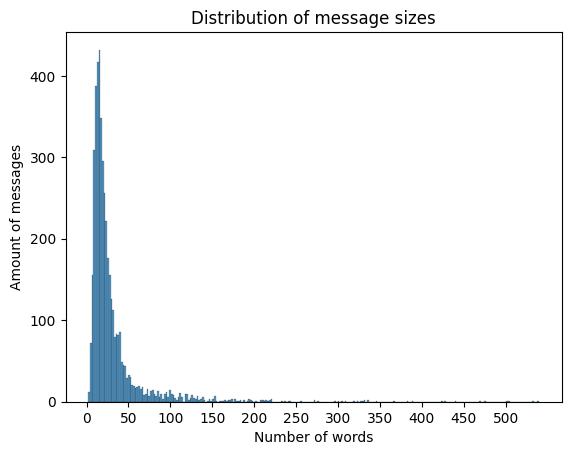

In [15]:
# Analyse lenght of messages
lengths = [len(message) for message in list_data]
print('Max lenght:', max(lengths))
print('Min lenght:', min(lengths))
longest_messages = (-np.array(lengths)).argsort()[:10]
sns.histplot(lengths)
plt.title('Distribution of message sizes')
plt.xlabel('Number of words')
plt.ylabel('Amount of messages')
plt.xticks(np.arange(0,550,50))
# plt.xlim([0,100]) # cut off to have good overview
plt.show()

In [16]:
from sentence_transformers import SentenceTransformer

# Pick embedder
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_model.max_seq_length = 512

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [18]:
import torch

tokenizer = embedding_model.tokenizer

# Tokenize sentences
tokenized_messages = tokenizer(data, padding=True, truncation=False, return_tensors='pt')

# Check how many messages cut-off by truncation of SBERT

num_tokens = torch.sum(tokenized_messages['input_ids'] > 0, dim=1)
# sns.histplot(num_tokens)
num_tokens = pd.Series(num_tokens)
bins = [0,256,512,1000] # Default truncation is after 256 and can be adjusted to max 512
num_tokens.value_counts(bins=bins)
print(num_tokens.value_counts(bins=bins))

# Truncation has barely any result. Also because urls blanked and digits removed

(-0.001, 256.0]    4459
(256.0, 512.0]     49  
(512.0, 1000.0]    13  
dtype: int64


In [19]:
# # Pre-calculate embeddings

# # Prepare data
# data = [" ".join(words) for words in dataset.get_corpus()]

# # Calculate embeddings
# embeddings = embedding_model.encode(data, show_progress_bar=True)

# # Save embeddings
# with open('/content/drive/MyDrive/2024/embeddings.npy', 'wb') as f:
#     np.save(f, embeddings)


Batches:   0%|          | 0/142 [00:00<?, ?it/s]

In [22]:
# Load embeddings
with open('/content/drive/MyDrive/2024/embeddings.npy', 'rb') as f:
    embeddings = np.load(f)

In [23]:
# Fix UMAP model with random state

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, low_memory = False, metric='cosine',random_state=1)

In [ ]:
# import gensim.downloader as api

# word2vec_model = api.load('word2vec-google-news-300')
# word2vec_model.save('/content/drive/MyDrive/2024/word2vec_model.kv')

In [28]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load('/content/drive/MyDrive/2024/word2vec_model.kv')

doc_ids = range(len(data))

In [29]:
# documents = pd.DataFrame({"Document": data,
#                           "ID": doc_ids,
#                           'Class':  raw_data['label']})

# baseline_evaluator =  Evaluator(documents, embeddings, topic_model = BERTopic(umap_model= umap_model), name = 'Original labeling', dataset =dataset, word2vec_model=word2vec_model)

# baseline_evaluator.score(save= f"/content/drive/MyDrive/2024/Original_ukraine")


Results
npmi: -0.018544220581432708
we: 0.028391425636993053
diversity: 0.4103448275862069
 


In [30]:
# Create class numbers for each label
label_to_num = {k: v for v, k in enumerate(pd.Series(raw_data['label']).unique())}
raw_data['label_num'] = raw_data['label'].map(label_to_num)

In [ ]:
# # Remove multiple occurences of the same character
# # from Tweettokenizer
#     pattern = re.compile(r"(.)\1{2,}")
#     return pattern.sub(r"\1\1\1", text)

In [31]:
# np.random.seed(1)

# if new_model:
#     for i in range(1):
#         params = {
#             'embedding_model': 'all-MiniLM-L6-v2',
#             'verbose': True,
#             'umap_model': umap_model,
#             'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True, metric='euclidean', cluster_selection_method='eom'), # min cluster size by default 10
#             'vectorizer_model': CountVectorizer(stop_words="english", ngram_range=(1, 2)), # default only ngram (1,1)
#             # 'representation_model': KeyBERTInspired(), # strongly influences measures depending on topic words
#         }

#         trainer = Trainer(dataset='/content/drive/MyDrive/2024/ukraine',
#                           model_name="BERTopic",
#                           params=params,
#                           bt_embeddings=embeddings,
#                           custom_dataset=True,
#                           verbose=True,
#                           word2vec_model=word2vec_model,
#                           semi_supervised=False,
#                           labels = raw_data['label_num'])
#         results, topic_model = trainer.train(save=f"/content/drive/MyDrive/2024/{model}/BERTopic_train_{i+1}")


#     # Save model
#     pointer_embedding = "sentence-transformers/all-MiniLM-L6-v2"
#     topic_model.save(f'/content/drive/MyDrive/2024/{model}', serialization="pytorch", save_ctfidf=True, save_embedding_model=pointer_embedding)

2024-01-23 15:03:04,100 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-23 15:03:36,766 - BERTopic - Dimensionality - Completed ✓
2024-01-23 15:03:36,768 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-23 15:03:38,209 - BERTopic - Cluster - Completed ✓
2024-01-23 15:03:38,217 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-23 15:03:38,679 - BERTopic - Representation - Completed ✓


Results
npmi: 0.015771333528701914
we: 0.0038603900905593846
diversity: 0.40120481927710844
kl background: 1.4343809214922383
 


In [32]:
# Load model
topic_model = BERTopic.load(f'/content/drive/MyDrive/2024/{model}')

# topics, probs = topic_model.transform(data, embeddings)

In [33]:
#%%

# Analyse results
print(topic_model.get_topic_info())
document_info = topic_model.get_document_info(data)
print(document_info)

    Topic  Count                                                 Name  \
0  -1      1365   -1_tell_good_hello_person                             
1   0      258    0_card_bank_money_account                             
2   1      136    1_parcel_send_send parcel_transfer                    
3   2      131    2_apartment_rent_housing_room                         
4   3      90     3_bratislava_job bratislava_looking_bratislava good   
.. ..      ..                                                     ...   
79  78     12     78_outages_power outages_power_stabilization          
80  79     12     79_border_border tell_bags_crossing border            
81  80     11     80_permit_slovakia_permit slovakia_residence permit   
82  81     11     81_presenter_presenter person_psychologist_group      
83  82     11     82_30___children_hockey_activities children           

                                                                                                                           

In [35]:
documents = pd.DataFrame({"Document": data,
                          "ID": doc_ids,
                          'Class':  document_info['Topic']})

bertopic_evaluator =  Evaluator(documents, embeddings, topic_model = topic_model, name = 'BERTopic', dataset =dataset, word2vec_model=word2vec_model)

bertopic_evaluator.score(save= f"/content/drive/MyDrive/2024/{model}/BERTopic_ukraine_1")

Results
npmi: 0.014632714037735787
we: 0.003918650320598059
diversity: 0.4
 


In [ ]:
# from OpenAI_BERTopic_repo import OpenAI

# summarization_prompt = """
# This is a list of texts where each collection of texts describe a topic. After each collection of texts, a summary that captures the most important content of the texts in the collections is provided.
# ---
# Topic:
# Sample texts from this topic:
# - Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
# - Meat, but especially beef, is the worst food in terms of emissions.
# - Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

# Keywords: meat beef eat eating emissions steak food health processed chicken
# Summary: Meat has become a bigger component of our diets. Eating meat is harmful for the enviroment.
# ---
# Topic:
# Sample texts from this topic:
# - I have ordered the product weeks ago but it still has not arrived!
# - The website mentions that it only takes a couple of days to deliver but I still have not received mine.
# - I got a message stating that I received the monitor but that is not true!
# - It took a month longer to deliver than was advised...

# Keywords: deliver weeks product shipping long delivery received arrived arrive week
# Summary: Some packages take a long time to get delivered. False claims about the delivery of packages are being made.
# ---
# Topic:
# Sample texts from this topic:
# [DOCUMENTS]
# Keywords: [KEYWORDS]
# Summary:"""

# representation_model= OpenAI(client,model = deployment_name, prompt = summarization_prompt, nr_docs=20, delay_in_seconds=3)
# representation_model.extract_topics(topic_model, documents.rename(columns={'Class':'Topic'}), topic_model.c_tf_idf_, topic_model.topic_representations_)

importing Jupyter notebook from /nbs/OpenAI_BERTopic_repo.ipynb


100%|██████████| 4/4 [00:14<00:00,  3.53s/it]


{-1: [('People are either asking questions or making demands related to cash assistance or where one can',
   1)],
 0: [('Various organizations and hotlines are providing humanitarian assistance to people seeking asylum or refugee status',
   1)],
 1: [('Questions and updates about the payment people receive for winter IDP. Different people have',
   1)],
 2: [('These texts talk about various social service centers across different locations in the world. These',
   1)]}

In [ ]:
# Select cluster to analyse
cluster_num = 36

In [83]:
from OpenAI_BERTopic_repo import OpenAI

summarization_chat_prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please write a summary that captures the most important content of this topic in the following format:
topic: <summary>
"""

representation_model = OpenAI(client, model=deployment_name, chat=True, prompt=summarization_chat_prompt, nr_docs=20, delay_in_seconds=3)
representation_model.extract_topics(topic_model, documents[documents['Class']==cluster_num].rename(columns={'Class':'Topic'}), topic_model.c_tf_idf_.getrow(cluster_num), {cluster_num:topic_model.topic_representations_[cluster_num]})

100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


{36: [('Buying and registering cars in Ukraine.\nThis topic includes inquiries about buying cars with Ukrainian registration and re-registering cars in different countries. Additionally, there are questions about driving with Ukrainian licenses in other countries, obtaining Ukrainian vignettes, and finding companies that can assist with registration when purchasing a car. There are also private messages with offers to buy cars on Ukrainian license plates or registration. Finally, there is a message about selling a car with complete re-registration.',
   1)]}

In [36]:
print(topic_model.get_topic_freq().head(11))

    Topic  Count
2  -1      1365 
3   0      258  
52  1      136  
53  2      131  
55  3      90   
37  4      90   
74  5      86   
23  6      86   
0   7      76   
17  8      75   
35  9      65   


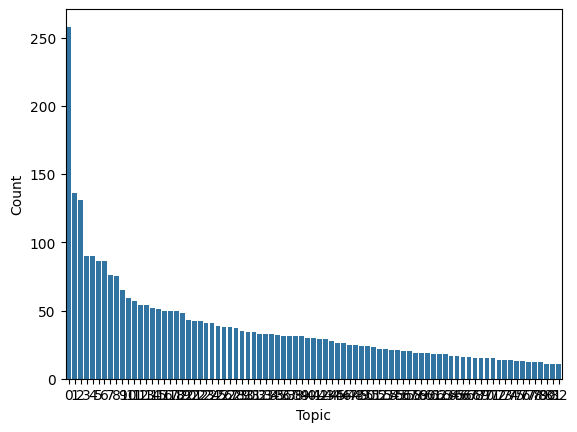

In [37]:
# Overview of cluster sizes
sns.barplot(y = 'Count', x = 'Topic', data=topic_model.get_topic_freq().iloc[1:])
plt.show()


In [38]:
# Check biggest cluster
print(document_info['Document'][document_info['Topic']== 0])

3       "Hello) who suspended 500+ due to departure from Poland (up to 30 days). What did you do? How quickly did the funds come? I called the zus hotline, they just waited..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
20      "Hello. Tell me please, maybe som

In [39]:
# Analyze clusters of large text messages

print(raw_data['text'].iloc[longest_messages])
print(document_info['Topic'].iloc[longest_messages])

# Check specific cluster
print('Longest cluster:', document_info['Top_n_words'].iloc[longest_messages[0]])
print(document_info['Document'][document_info['Topic']== document_info['Topic'].iloc[longest_messages[0]]])

1977    "**How to cancel temporary protection issued by Slovakia** ❓\n\nIf you are in Bratislava, submit an application to the police station on Botova 7, and if in another city - write to us and we will find out where to approach you. \n\n**Where to get the application** ❓\n\nOn Botov 7 - with lawyers (they can help fill it out), in other cities - right in the department that will consider your application. \n\nWe also attach a link to the application form [**HERE](<URL>)**. \n\n**What other documents need to be submitted** ❓\n\nThe police need to provide a copy or original of your temporary protection (odidenec/docasne utocisko). \n\nWe recommend providing a copy and keeping the original to yourself. If you give the original - make yourself a copy or photo.\n \n**Where to find <PERSON> and identifikátor ❓\n** \nThis data is indicated on your temporary protection document. \n\n**How long will the police review the❓ application** \n\nAs a general rule, the police consider the applicati

In [40]:
topic_model.visualize_topics()

In [43]:
heatmap = topic_model.visualize_heatmap()
heatmap.show()

In [58]:
#%%

# Check specific cluster
print(document_info['Document'][document_info['Topic']== 36])

518     Good evening! Please tell me how to call a taxi from a Ukrainian number.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
709     "I provide passenger transportation services throughout Ukraine, at a bargain price, in a comfortable car) Contact Direct"                                                                                                                                                                                                 

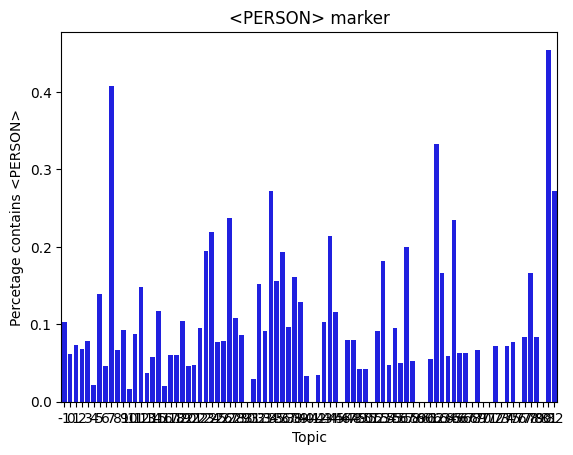

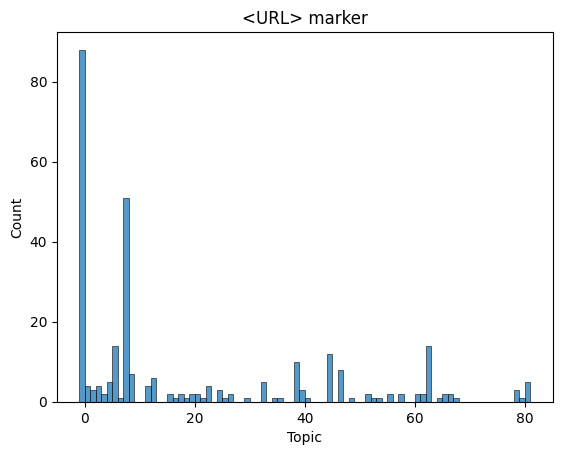

In [44]:
#%%

# Check if not focussing on marker tokens
# Could potentionally check with tf-idf score
# Now because of preprocessing punctuation is removed, so markers not this specific anymore

pers_topics = pd.concat([document_info['Topic'],raw_data['text'].str.contains('<PERSON>')],axis=1)
freq_pers = pers_topics.groupby(['Topic'], as_index=False).mean()
sns.barplot(x = 'Topic', y= 'text', data=freq_pers, color='b')
plt.title('<PERSON> marker')
plt.ylabel('Percetage contains <PERSON>')
plt.show()

url_topics = document_info['Topic'][raw_data['text'].str.contains('<URL>')]
sns.histplot(url_topics, binwidth=1)
plt.title('<URL> marker')
plt.show()

In [45]:
# Get matrix with for every word the importance for that topic and the corresponding words
topic_term_matrix = topic_model.c_tf_idf_.toarray()
words = topic_model.vectorizer_model.get_feature_names_out()

# Get the column corresponding to person
person_col = np.where(words=='person')[0]

# Get for each topic the ranking on how important person is
person_importance = np.where(np.argsort(-topic_term_matrix)==person_col)[1]

# Get the ranking for the topic where it's most important (exclude the outliers)
max_importance = np.min(person_importance[1:])
print(max_importance)

14


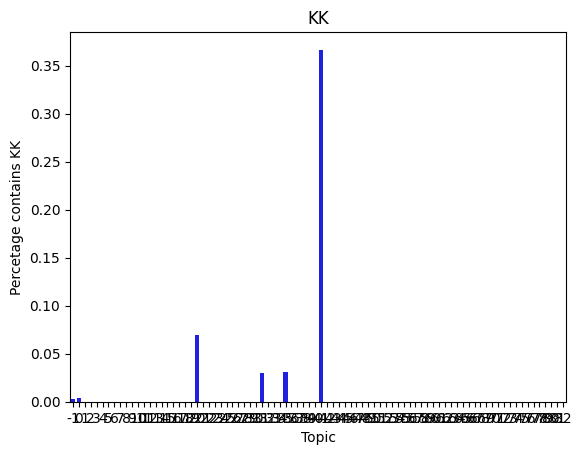

In [46]:
KK_topics = pd.concat([document_info['Topic'],raw_data['text'].str.contains(' KK ')],axis=1)
freq_KK = KK_topics.groupby(['Topic'], as_index=False).mean()
sns.barplot(x = 'Topic', y= 'text', data=freq_KK, color='b')
plt.title('KK')
plt.ylabel('Percetage contains KK')
plt.show()


In [47]:
#%%

# Ditribution over topics

topic_distr, _ = topic_model.approximate_distribution(data, window=8, stride=4)
topic_model.visualize_distribution(topic_distr[0], custom_labels=True)

# Maybe nice for long messages

100%|██████████| 5/5 [00:00<00:00, 10.48it/s]


In [48]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(data, calculate_tokens=True)

# Visualize the token-level distributions
topic_model.visualize_approximate_distribution(data[0], topic_token_distr[0])

100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


In [49]:
topics_per_class = topic_model.topics_per_class(raw_data['text'], classes=raw_data['label'])

topic_model.visualize_topics_per_class(topics_per_class)

29it [00:02, 12.62it/s]


In [50]:
# Assign an original label to topics if more than a threshold percentage of the messages in the topic originate from that label

threshold = 0.7
raw_data['topic']= document_info['Top_n_words']
clustered_only = raw_data[document_info['Topic']!=-1] # Exclude outliers

# Count the number of occurences of each label within each topic
label_count = clustered_only[['topic', 'label']].groupby(['topic', 'label']).size().reset_index(name='count')

# Obtain the frequency how much of the topic originated from which label
label_count['freq'] = label_count.groupby(['topic'])['count'].apply(lambda x: x / x.sum()) # DataFrame containing per topic the distribution over the original labels

# Say a topic is a refinement if more that the threshold originated from the same label
clear_refined = label_count[label_count['freq']>=threshold][['label', 'freq', 'topic']]
print(str(len(clear_refined)), ' topics originate clearly from refinement on labeling')
print(clear_refined.groupby(['label'])['label', 'topic'].apply(print))


34  topics originate clearly from refinement on labeling
       label  \
462  ANOMALY   

                                                                                                                                           topic  
462  vaccination - certificate - vaccination certificate - european - covid - medical - worldwide - valid worldwide - medical examination - diya  
        label  \
0    CHILDREN   
423  CHILDREN   

                                                                                                                   topic  
0    30__ - children - hockey - activities children - 00__ - creative - years - district - activities - couple            
423  sports - sections - football - sports sections - coach - knows sports - gym - sections children - figure - children  
            label  \
194  CONNECTIVITY   
218  CONNECTIVITY   
258  CONNECTIVITY   
418  CONNECTIVITY   

                                                                                         

In [51]:
# Get topics that are not from a parcticular label

potential_new = label_count[label_count['freq']<threshold][['label', 'freq', 'topic']]
covered_topics = clear_refined['topic'].tolist()

# Exclude refinement topics
potential_new = potential_new[~potential_new['topic'].isin(covered_topics)]

# Order topics based on being least certain to be part of the refinement
potential_new = potential_new.groupby('topic')['freq'].max().reset_index(name='certainty') # Get the assignment score to the label it was most likely to occur
potential_new = potential_new.sort_values('certainty')
print(potential_new)


                                                                                                                                                                  topic  \
46  url - assistance - 00 - persons - displaced - url assistance - assistance ukrainians - ukrainians - humanitarian - people                                             
9   chisinau - chisinau tell - chisinau good - good - tell chisinau - temporary asylum - yandex - time banks - later good - accept payment                                
2   bratislava - job bratislava - looking - bratislava good - job - tell bratislava - buy - bratislava buy - good - bratislava hello                                      
21  moldova - passport - border - cross border - 90 - republic moldova - border moldova - issue temporary - possible - moldovan                                           
37  qc - products qc - qc good - products - vz - need register - application - today qc - come qc - qc program                                   

In [52]:
document_info['Document'][document_info['Top_n_words'] ==  potential_new['topic'].iloc[0]]

0       "Hello everyone! Regarding help from the Good Samaritan (Hope for Ukraine) in Lviv. It is worth subscribing to them on Facebook: from time to time they post a form that must be filled out to receive assistance. Assistance is issued only once. 📎 It is necessary to register in the form separately for separate emails. Each child on a different email. It happens that they do not have time to register all family members, because the form closes quickly. After successful registration, a confirmation comes to the email, which indicates the address, date and time of receipt. 📎 Then you need to come to Vynnyky on Lisna, 1 — bus number 29 runs from Lviv railway station for an hour. Delivery on the territory of the church ""Good Samaritan"". No matter the weather, everyone is waiting outside. 📎 The room is launched alphabetically, so if you have an issue from 10:00, then you need to come exactly at 10, and then follow which letters enter. If you miss your letter, you can enter after the e

In [54]:
from sklearn.metrics.cluster import pair_confusion_matrix

def refinement_RI(topics, labels, leave_out = [-1]):
  """
  Caluclates the refinement Rand Index score while leaving out some topics

  Input:
  topics: the refined topics
  labels: the original labeling
  leave_out: a  list of topic numbers to hold out. By default only exclude outliers

  Returns the refinement RI
  """
  # Exclude the specified topics
  labels = labels[~topics.isin(leave_out)]
  topics = topics[~topics.isin(leave_out)]

  # Measure on refinement; inspired on Rand Index
  contingency = pair_confusion_matrix(topics, labels)
  RI = contingency[1][1]/(contingency[1][1]+contingency[1][0]+contingency[0][0])
  return RI

print(refinement_RI(document_info['Topic'], raw_data['label']))

0.01193653325741803


In [55]:
from sklearn.metrics import silhouette_score

# Obtain the umap embeddings
umap_embeddings = topic_model.umap_model.transform(embeddings)

# Exclude outliers
umap_embeddings = umap_embeddings[document_info['Topic']!=-1]
clustering = document_info['Topic'][document_info['Topic']!=-1]

# Calculate silhouette score
print(silhouette_score(umap_embeddings, clustering))


0.04951706
